# Setup files

In [1]:
#Setup files
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#This libary help to read excel ordinal datatime
import xlrd
#Improt subplot package and go package of ploty express
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#Assign dataset
df_trans= pd.read_csv("Transaction_ID.csv")
df_customerid = pd.read_csv("Customer_ID.csv")
df_city= pd.read_csv("City.csv")
df_cab = pd.read_csv("Cab_Data.csv")
#Merge 3 dataset cab, trans, cus into df_merge
df_merge = df_trans.merge(df_customerid, on="Customer ID").merge(df_cab, on="Transaction ID")

#City.csv file
#Use regex to remove "," with replace and astype to change string to int for Population and users
user_df= df_city
user_df[['Population','Users']]= user_df[['Population','Users']].replace(r'\D+', '', regex=True).astype('int64')

# Checking Missing and Duplicated value in datasets 

In [2]:
#Check for missing data
for col in df_merge.columns:
    pct_missing = np.mean(df_merge[col].isnull())
    print('{} - {}'.format(col,pct_missing))
    
#No missing data


Transaction ID - 0.0
Customer ID - 0.0
Payment_Mode - 0.0
Gender - 0.0
Age - 0.0
Income (USD/Month) - 0.0
Date of Travel - 0.0
Company - 0.0
City - 0.0
KM Travelled - 0.0
Price Charged - 0.0
Cost of Trip - 0.0


In [3]:
for col in df_customerid.columns:
    pct_missing = np.mean(df_customerid[col].isnull())
    print('{} - {}'.format(col,pct_missing))
#No missing data

Customer ID - 0.0
Gender - 0.0
Age - 0.0
Income (USD/Month) - 0.0


# Prepare datasets

In [4]:
#Change date to datetime
#Definite a function to read excel ordinal date
def read_date(date):
    return xlrd.xldate.xldate_as_datetime(date, 0)
    
df_merge['Date'] = pd.to_datetime(df_merge['Date of Travel'].apply(read_date), errors='coerce', format='%Y-%m-%d')

#Rename columns
df_merge.rename(columns={"Transaction ID":"Transaction"}, inplace=True)
#Create Month and year column to get data from Date column
months=[]
years =[]
for i in range(len(df_merge['Date'])):
    months.append(df_merge['Date'][i].month)
    years.append(df_merge['Date'][i].year)
df_merge['Month'] = months
df_merge['Year'] = years
df_merge['Day of Week'] = df_merge['Date'].dt.day_name()

In [5]:
#Prepare subdatasets 
#Split data into Yellow and Pink Company
Pink_df = df_merge[df_merge['Company']=='Pink Cab']
Yellow_df = df_merge[df_merge['Company']=='Yellow Cab']

## Check Travel Frequency

In [6]:

#Creat plot by months
pink_plot_M = df_merge[df_merge.Company=='Pink Cab'].groupby(['Month']).Transaction.count()
yellow_plot_M = df_merge[df_merge.Company=='Yellow Cab'].groupby(['Month']).Transaction.count()


# Testing Hypothesis

## 1) Is there any pattern for travel frequency by Months?
### Plot travel frequency by Months


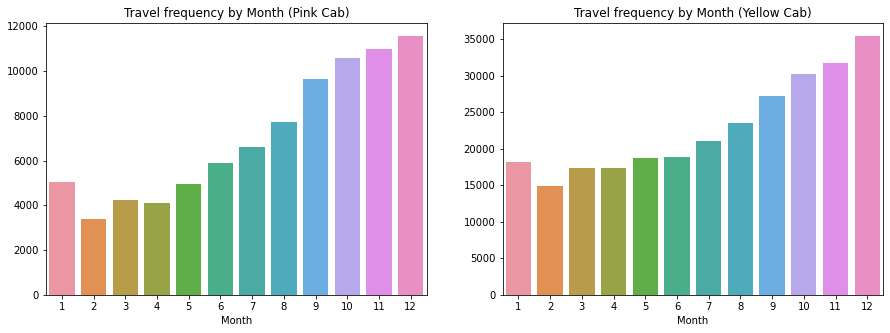

In [7]:
#Plot travel frequency by Months
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.barplot(x=pink_plot_M.index,y=pink_plot_M.values)
plt.title('Travel frequency by Month (Pink Cab)')

plt.subplot(122)
sns.barplot(x=yellow_plot_M.index,y=yellow_plot_M.values)
plt.title('Travel frequency by Month (Yellow Cab)')
plt.show()


Yellow Cab has total higher travels compared to Pink Cab. In summertime (June-August) to December, both companies has been experienced the increasing travel frequency, which the higest travel's month is December. December was the busiest month for travelling in both companies because of the biggest holiday in the US: Christmas and winterbreak seasons


## 2) Is there any daily pattern for Counts of trip in comparison of companies?

#### Count of trips by Days of a week 

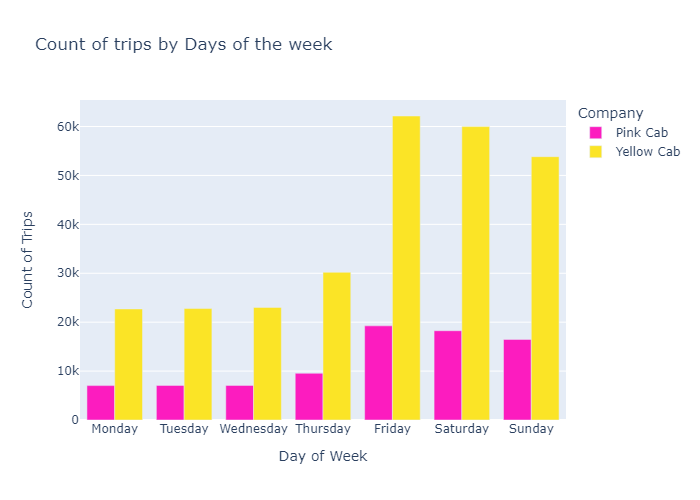

In [8]:
temp_df = df_merge.groupby(['Company','Day of Week']).agg({"Transaction":"count"}).reset_index()
#create a mapping of the sort order
sort_order = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5, 'Saturday':6,'Sunday':7}

#create new column with the sort order
temp_df['sort_columns'] = temp_df['Day of Week'].map(sort_order)

#sort with sort_column

temp_df = temp_df.sort_values('sort_columns').drop('sort_columns',axis=1).reset_index(drop=True)

fig = px.bar(temp_df, x="Day of Week", y="Transaction", color= "Company", barmode='group', title="Count of trips by Days of the week",
             color_discrete_map={'(?)':'black', 'Pink Cab':'#FC1CBF', 'Yellow Cab':'#FBE426'})
fig.update_yaxes(title_text='Count of Trips')
fig.show('png')

Overall, Yellow Cab is the top choice for customer when riding in day of a week with more than 60000 rides compared to 20000 rides from Pink Cab. 

Both companies have the same pattern for day of a week: it start increase dramatically from Thursday to Friday and starts to decrease from Sunday. 

Friday is the busiest day in a week for both two cab companies, the customers riding with both companies are higher compared to other days. 


# Creating Master dataset from 4 datasets


In [9]:
# Merge City.csv to the rest of data to create Master Data for later analysis
data= df_merge.merge(df_city, on ="City", how='inner')

# Check Profit in both companies

In [10]:
#Rename Income column 
data.rename(columns={"Income (USD/Month)" : "Income"}, inplace=True)
#Profit aftet deduct Cost
data['Profit'] = (data['Price Charged']-data['Cost of Trip'])
data.head(n=5)

,Transaction,Customer ID,Payment_Mode,Gender,Age,Income,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Date,Month,Year,Day of Week,Population,Users,Profit
0,10000011,29290,Card,Male,28,10813,42377,Pink Cab,ATLANTA GA,30.45,370.95,313.6350,2016-01-08,1,2016,Friday,814885,24701,57.3150
1,10351127,29290,Cash,Male,28,10813,43302,Yellow Cab,ATLANTA GA,26.19,598.70,317.4228,2018-07-21,7,2018,Saturday,814885,24701,281.2772
2,10412921,29290,Card,Male,28,10813,43427,Yellow Cab,ATLANTA GA,42.55,792.05,597.4020,2018-11-23,11,2018,Friday,814885,24701,194.6480
3,10000012,27703,Card,Male,27,9237,42375,Pink Cab,ATLANTA GA,28.62,358.52,334.8540,2016-01-06,1,2016,Wednesday,814885,24701,23.6660
4,10320494,27703,Card,Male,27,9237,43211,Yellow Cab,ATLANTA GA,36.38,721.10,467.1192,2018-04-21,4,2018,Saturday,814885,24701,253.9808


## 3) Which company has higher profit?

Profit is identified as Revenue - Expense and in here Profit= Price Chared - Cost of Travel

In [11]:
#Groupby Year, and Company
year_df = data.groupby(["Company", "Year"]).agg({'Profit': sum, 'KM Travelled': sum, "Transaction" : "count"})

year_df.rename(columns={"Transaction": "No of Customers", "KM Travelled" : "KM"}, inplace=True)
#Profit per trip

year_df ['profit_trip']= round(year_df['Profit'] / year_df ['No of Customers'],2)
#Profit per KM travlled
year_df ['profit_km'] = round(year_df ['Profit'] / year_df ['KM'],2)

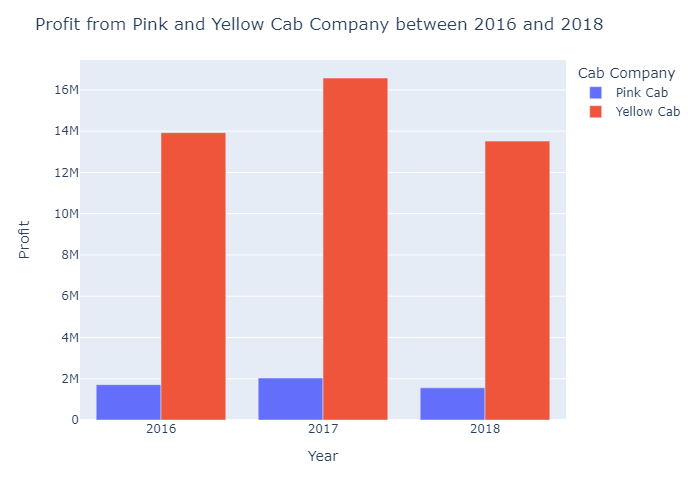

In [12]:
#Overall Profit by yearly
profit_yr= year_df.reset_index().pivot(columns='Company', index='Year', values='Profit')
profit_yr.index = profit_yr.index.astype(str)

#Create plot

fig = px.bar(profit_yr, labels=dict(value="Profit", Company="Cab Company"))
fig.update_layout(barmode="group")
fig.update_layout(title_text='Profit from Pink and Yellow Cab Company between 2016 and 2018')
fig.show('png')

In general, Yellow Cab has higher profit from 2016 to 2018 compared to Pink Cab. 
From 2016 to 2017, both Yellow and Pink Cab had been experienced the increase in Profit. For Yellow Cab, 2016 was the most successful year with roughly 16.57 million dollars compared to nearly 2 million dollars from Pink Cab. 

However, 2018 had been experienced the dramatically decrease in profit of both company but it was a big impact for their company with the loss up to nearly  3 million dollars.

Overall, Yellow Cab still the biggest Cab company dominated the market from 2016 to 2018, which up to 70% percentage of the martket while Pink Cab only accounted for 30% of the martket. 



## 4) How much profit each company can generate per Customer and per KM
### Check average profit per KM and per Customer

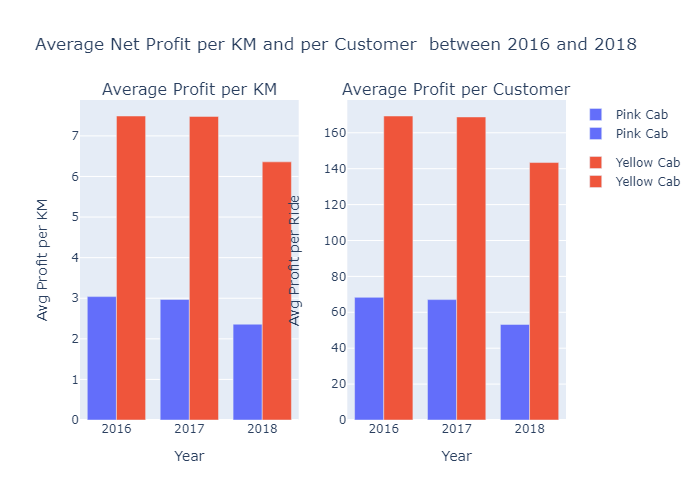

In [13]:
#Avg_per KM
avg_km= year_df.reset_index().pivot(columns='Company', index='Year', values='profit_km')
avg_km.index = avg_km.index.astype(str)
#Avg per Trip
avg_trip= year_df.reset_index().pivot(columns='Company', index='Year', values='profit_trip')
avg_trip.index = avg_km.index.astype(str)

#Create subplot 
bar1 = px.bar(avg_km,
              labels=dict(value="Average Profit per KM", Company="Cab Company"))
bar2 = px.bar(avg_trip,
              labels=dict(value="Average Profit per KM", Company="Cab Company"))

fig = make_subplots(rows=1, cols=2, 
subplot_titles=("Average Profit per KM", "Average Profit per Customer"))
for trace in bar1.data:
    fig.add_trace(trace, 1, 1)
for trace in bar2.data:
    fig.add_trace(trace, 1, 2)

fig.update_layout(barmode="group")
fig.update_layout(title_text='Average Net Profit per KM and per Customer  between 2016 and 2018')

# edit axis labels
fig['layout']['xaxis']['title']='Year'
fig['layout']['xaxis2']['title']='Year'
fig['layout']['yaxis']['title']='Avg Profit per KM'
fig['layout']['yaxis2']['title']='Avg Profit per Ride'
fig.show('png')

For Yellow Cab, each ridescan generate for the company 7.49, 7.48 and 6.36 dollars in 2016, 2017 and 2018 respectively. In contrast, this number is lower for Pink Cab with 3.04, 2.97 and 2.36 dollar respectively in the same year range. For each customer riding with Yellow Cab, each customer brought 169.35, 168.82 and 143.42 dollars from 2016 to 2018 respectively whereas this number is 68.32, 67.07 and 53.23 dollars respectively. 

### Check Profit by days of a week

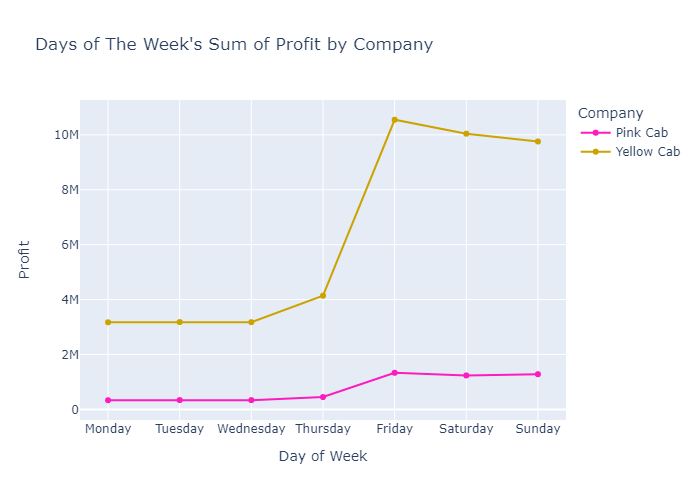

In [14]:
temp_df_p = data.groupby(['Company', 'Day of Week']).agg({"Profit":"sum"}).reset_index()
#create a mapping of the sort order
sortbox = {'Monday':1,'Tuesday':2,'Wednesday':3,'Thursday':4,'Friday':5, 'Saturday':6,'Sunday':7}

#create new column with the sort order
temp_df_p['sort_column'] = temp_df_p['Day of Week'].map(sortbox)

#sort with sort_column

temp_df_p = temp_df_p.sort_values('sort_column').drop('sort_column',axis=1).reset_index(drop=True)

fig = px.line(temp_df_p, x="Day of Week", y="Profit", color= "Company", title="Days of The Week's Sum of Profit by Company", color_discrete_map={'(?)':'black', 'Pink Cab':'#FC1CBF', 'Yellow Cab':'#cca300'})
fig.update_traces(mode='markers+lines')
fig.show('png')

Yellow in general has higher profit compared to Pink Cab in everyday. For Yellow cab's Profit started to increase from Wednesday day to reach a peak on Friday and decrease slowly to Sunday. In contrast Pink Cab had a stable profit in everyday of a week with the slightly increase from Thursday to Friday. 






### Check Profit by Month

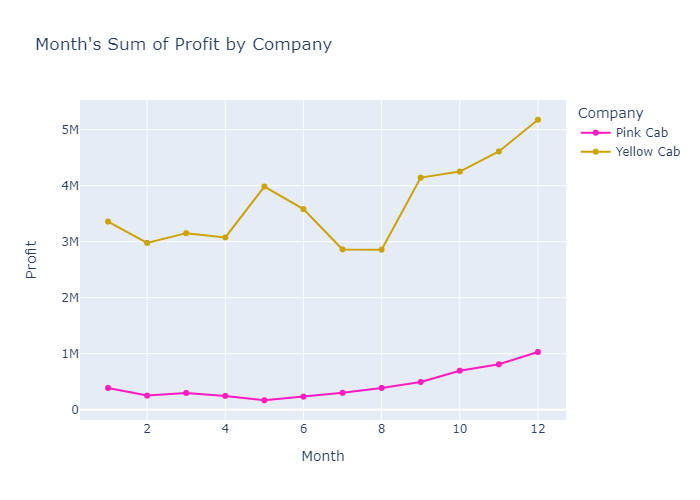

In [30]:
#Check profit by Month
month_profit = data.groupby(['Company', 'Month']).agg({"Profit":"sum"}).reset_index()

fig = px.line(month_profit, x="Month", y="Profit", color= "Company", title="Month's Sum of Profit by Company", color_discrete_map={'(?)':'black', 'Pink Cab':'#FC1CBF', 'Yellow Cab':'#cca300'})
fig.update_traces(mode='markers+lines')
fig.show('png')

Yellow in general has higher profit compared to Pink Cab in every month. Profit from both companies starts to increase from August to December. 

December is the busiest month, and the most profitable month in the year for both companies. For Yellow Cab, they can make more than 5 million USD dollar compared to only 1 million USD dollar from Pink Cab. 

However, the profit line from Yellow not stable compared to Pink Cab, where their profit line does not change dramatically. 




## 5) Which company has higher Price Charged?

In [15]:
#Check overall Price in both companies
Overall_price = data['Price Charged'].describe()
Pink_price = Pink_df['Price Charged'].describe()
Yellow_price = Yellow_df['Price Charged'].describe()

Price = pd.DataFrame({'Overall': Overall_price.values,
                  'PinkCab': Pink_price.values,
                  'YellowCab': Yellow_price.values}, index= ['Count', 'Mean', 'Std. Dev.', 'Min', '25%', '50%', '75%', 'Max'])
Price

,Overall,PinkCab,YellowCab
Count,359392.000000,84711.000000,274681.000000
Mean,423.443311,310.800856,458.181990
Std. Dev.,274.378911,181.995661,288.386166
Min,15.600000,15.600000,20.730000
25%,206.437500,159.970000,226.680000
50%,386.360000,298.060000,425.060000
75%,583.660000,441.505000,633.880000
Max,2048.030000,1623.480000,2048.030000


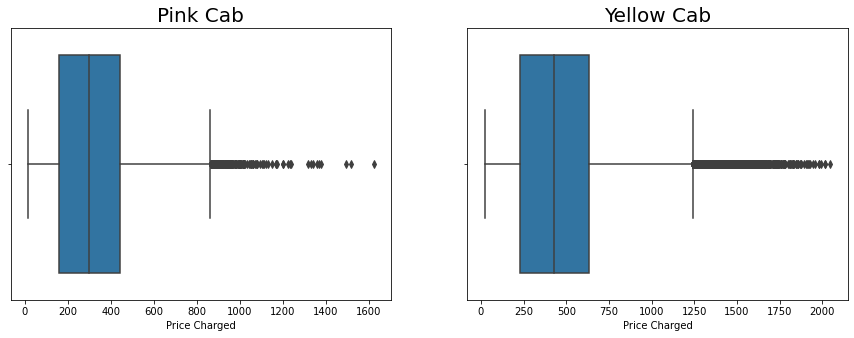

In [16]:
#Outliers
fig = plt.figure(figsize=(15,5))
plt.subplot(121)
sns.boxplot(x= Pink_df['Price Charged'])
plt.title('Pink Cab', fontsize=20)
plt.subplot(122)
sns.boxplot(x= Yellow_df['Price Charged'])
plt.title('Yellow Cab', fontsize=20)
plt.show()


## Summary
Yellow Cab has more Price Charged than Pink Cab
We will keep the outliers because these outliers are due to the fee usage of expensive cars

## 6 ) Is there any corrlation between Price and Distance?

In [17]:
#Find Correlation betwen variables
data_df = data[['KM Travelled','Price Charged','Cost of Trip','Month','Year','Age','Income','Profit', 'Users', 'Population']]
data_df.corr()

,KM Travelled,Price Charged,Cost of Trip,Month,Year,Age,Income,Profit,Users,Population
KM Travelled,1.000000,0.835753,0.981848,-0.001903,-0.001072,-0.000369,-0.000544,0.462768,-0.000428,-0.002311
Price Charged,0.835753,1.000000,0.859812,-0.061116,-0.036409,-0.003084,0.003228,0.864154,0.281061,0.326589
Cost of Trip,0.981848,0.859812,1.000000,-0.008370,-0.001773,-0.000189,-0.000633,0.486056,0.023628,0.015108
Month,-0.001903,-0.061116,-0.008370,1.000000,-0.030490,-0.002226,0.000322,-0.096352,0.036558,0.064571
Year,-0.001072,-0.036409,-0.001773,-0.030490,1.000000,-0.000579,-0.001617,-0.060567,-0.000771,0.000003
Age,-0.000369,-0.003084,-0.000189,-0.002226,-0.000579,1.000000,0.003907,-0.005093,-0.005906,-0.009002
Income,-0.000544,0.003228,-0.000633,0.000322,-0.001617,0.003907,1.000000,0.006148,0.010464,0.011868
Profit,0.462768,0.864154,0.486056,-0.096352,-0.060567,-0.005093,0.006148,1.000000,0.457758,0.544079
Users,-0.000428,0.281061,0.023628,0.036558,-0.000771,-0.005906,0.010464,0.457758,1.000000,0.915490
Population,-0.002311,0.326589,0.015108,0.064571,0.000003,-0.009002,0.011868,0.544079,0.915490,1.000000


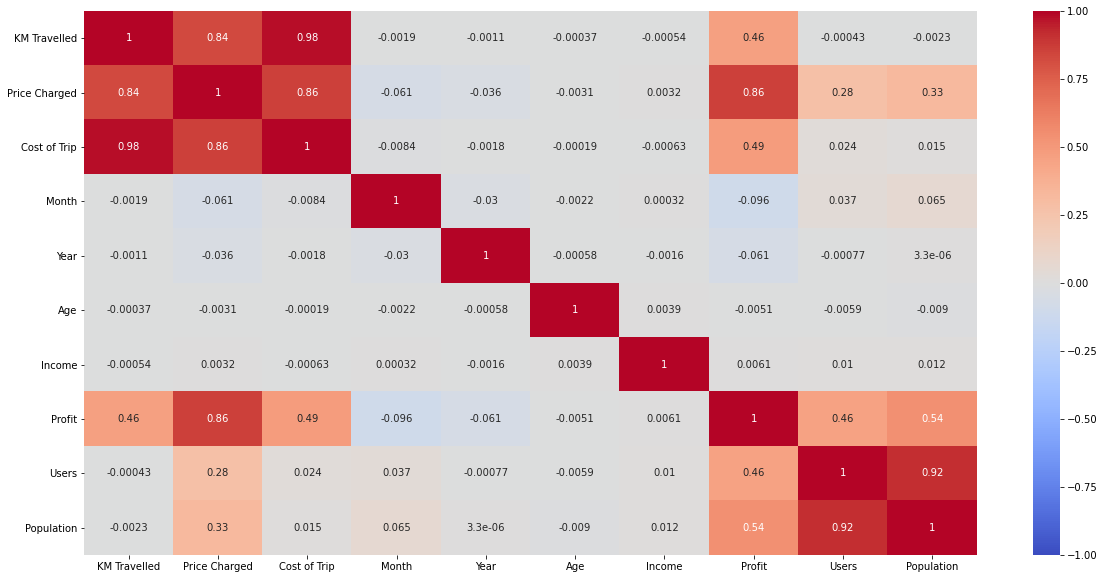

In [18]:
#Heat map 
plt.figure(figsize=(20,10))
sns.heatmap(data_df.corr(),annot=True,vmin=-1,vmax=1,cmap='coolwarm')
plt.show()

There is a correlation between Profit & Price Charged around 0.86, Population and Users:0.92, Cost of Trips and KM Travelled: 0.98, Price Charged and KM travelled: 0.84. It is clearly to say that Price Charged and KM Travelled or Distance have a  correlation. 


### Checking the correlation between Price and Distance between two companies

### What is the distance range between two companies

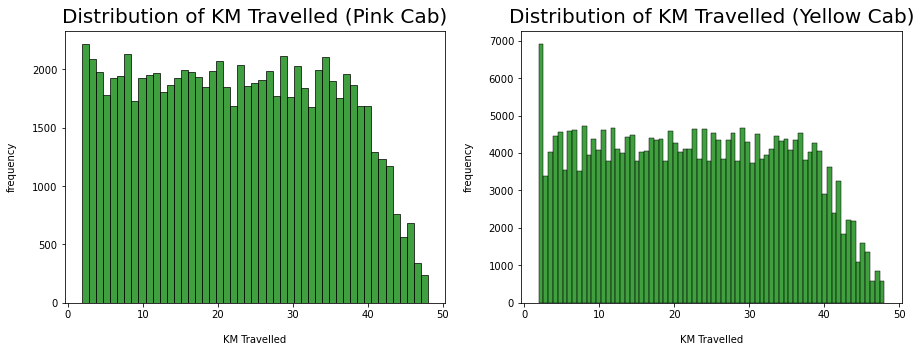

In [19]:
# Check the Range of  Distance by 2 companies
fig = plt.figure(figsize=(15,5))

plt.subplot(121)
ax = sns.histplot(Pink_df['KM Travelled'], kde=False, color='green')
plt.title("Distribution of KM Travelled (Pink Cab)", fontsize=20, y=1.012)
plt.xlabel("KM Travelled", labelpad=15)
plt.ylabel("frequency", labelpad=15)

plt.subplot(122)
ax = sns.histplot(Yellow_df['KM Travelled'], kde=False, color='green')
plt.title("Distribution of KM Travelled (Yellow Cab)", fontsize=20, y=1.012)
plt.xlabel("KM Travelled", labelpad=15)
plt.ylabel("frequency", labelpad=15)

plt.show()


From the above graphs and table, most of the rides start from 2KM to 48 KM. 


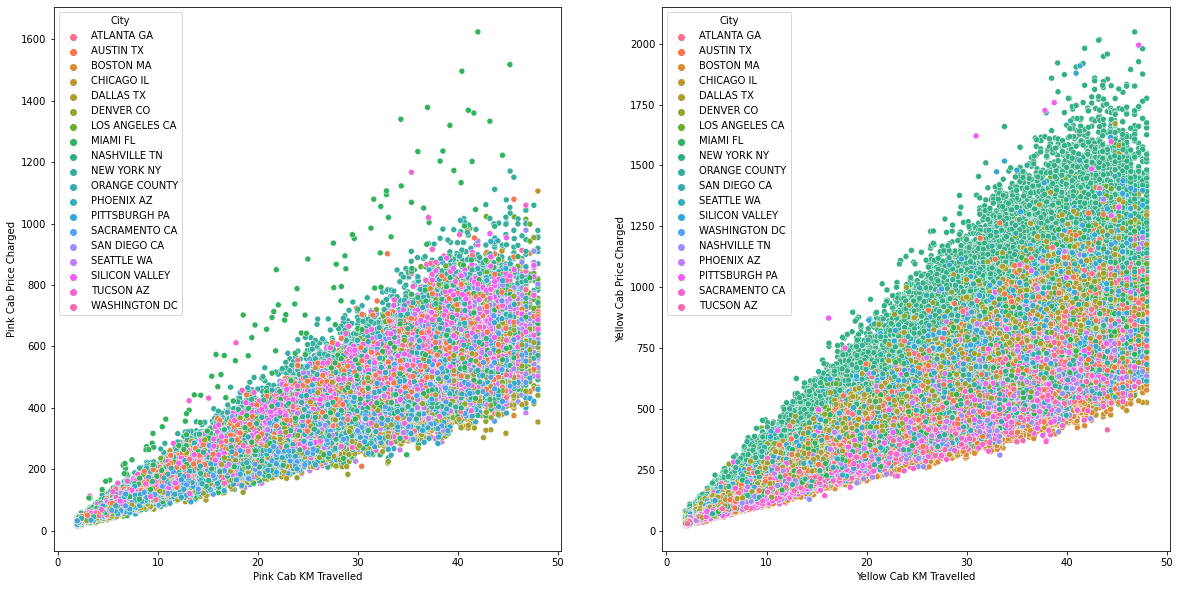

In [20]:
#Price Charged vs Distance in different cities
plt.figure(figsize=(20,10))
plt.subplot(121)
sns.scatterplot(data=Pink_df, x=Pink_df["KM Travelled"], y=Pink_df['Price Charged'], hue="City")
plt.ylabel('Pink Cab Price Charged')
plt.xlabel('Pink Cab KM Travelled')
plt.subplot(122)
sns.scatterplot(data=Yellow_df, x=Yellow_df["KM Travelled"], y=Yellow_df['Price Charged'], hue="City")
plt.ylabel('Yellow Cab Price Charged')
plt.xlabel('Yellow Cab KM Travelled')
plt.show()

## Summary
There are strong and positive correlation between Price and Distance in both two cab companies. Price for riding with Yellow Cab is higher compared to Pink Cab.Distance (KM) is one of important factors, which could impact the price when riding, and most of the rides start from 2KM to 48KM

At New York City, the Yellow Cab price charged is more in comparison to the other cities. In contrast, all cities have the same increase in prices with increase in distance when riding with Pink Cab

Some of the outliers in both graph might be due to special situation such as extreme weathers, rush hours, or high-end cars service

Distance is one of the important factor, but some outliers suggest that it could be from different factors such as weathers, rush hours, and high-end service to higer price charged. For example, New York is one of the busiest city, and this city is expensive, and always under traffic jam for hours. The longer customers waiting under traffic jam while riding with Yellow Cab could contribute to higher Price Charged. 

Therefore, Distance is one of the factor could associate the higher price charged but we will need more data to conclude the causable connection between Distance and Price Charged






## 7) How's the distribution of customers in cities for each companies?
### Overall distribution of customers in different cities

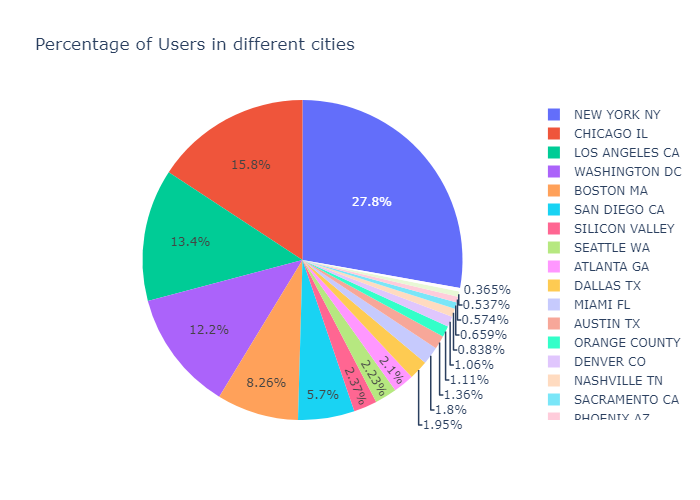

In [21]:
#Percentage of Users
city_users = data.groupby('City').agg({"Users":"count"})
city_users.reset_index(inplace=True)
fig = px.pie(city_users, values='Users', names='City', title='Percentage of Users in different cities ')
fig.show('png')

New York City has the highest Cab users with 27.8%. Chicago, Los Angles and Washington are also contributed to high number of users with 15.8%, 13.4% and 12.2% respectively.


### Distribution number of customers in different cities for Yellow and Pink Cab

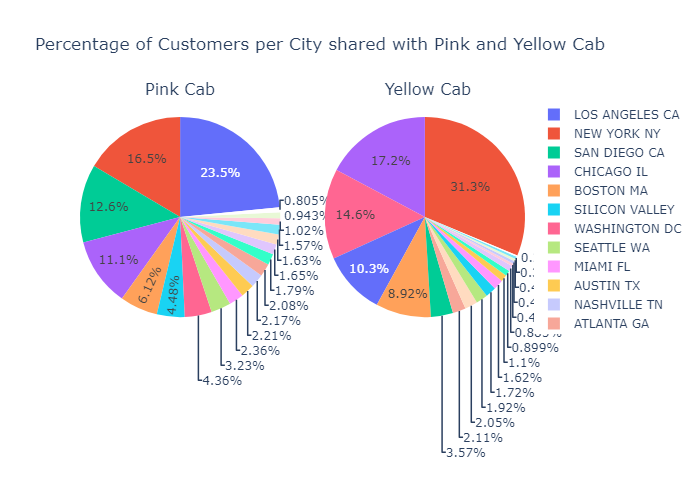

In [22]:
# Transaction between Yellow and Pink Company
city_p = data[data.Company=='Pink Cab'].groupby('City').agg({"Customer ID": "count"})
city_p.reset_index(inplace=True)
city_y = data[data.Company=='Yellow Cab'].groupby('City').agg({"Customer ID": "count"})
city_y.reset_index(inplace=True)
#this line to specific to create two pie charts
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]],
                    subplot_titles=("Pink Cab", " Yellow Cab") )

# add information
pie1 = px.pie(city_p, values='Customer ID', names='City', 
              title='Percentage of Users in different cities ')
pie2 = px.pie(city_y, values='Customer ID', names='City', 
              title='Percentage of Users in different cities ')

#Location of subplots
for trace in pie1.data:
    fig.add_trace(trace, 1, 1)
for trace in pie2.data:
    fig.add_trace(trace, 1, 2)
# Options of bar chart

fig.update_layout(title_text='Percentage of Customers per City shared with Pink and Yellow Cab')
fig.show('png')

## Summary
New York City is one of popular cities, which brought most of the profit for two companies with the numbers of users are nearly  86,000 (31.3%) for Yellow Cab compared to nearly 20,000 (23.5%) customers for Pink Cab. 

Only the number of customers riding with Pink Cab in Los Angeles followed by San Diego higher than Yellow Cab with 23.5% and 12.6% respectively compared to 10.3% and 3.5%. 

## 8) How's the distribution of customers in big cities (Population >1M) for each companies?

Big cities here are identified the cities has more than 1 million population and customer's income also more than $5000/monthly

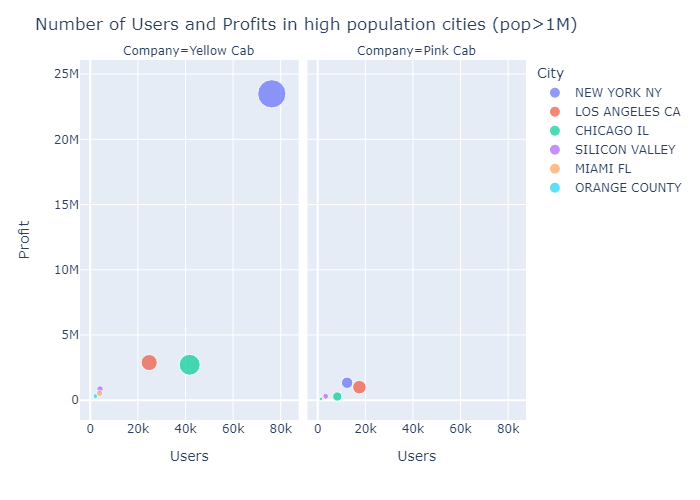

In [23]:
# Big overall picture about Two companies in big cities
#Income subset
Up = data[(data['Population']>1000000)&(data['Income']>5000)].groupby(['City',"Company"]).agg({"Users":"count", "Profit": "sum", "Population": "count"}).sort_values(by=["Profit",'Users'], ascending=False)
Up.reset_index(inplace=True)
#plot for overview 

fig = px.scatter(Up, y="Profit", x="Users", color='City', size='Population', facet_col="Company")
fig.update_layout(title_text='Number of Users and Profits in high population cities (pop>1M)')
fig.show('png')

## Summary
After subset dataset only select the high population cities (more than 1 million population) and select customer with income more than 5000 month, there are some clearly facts based on the two charts, and a table for two companies:

Yellow Cab has a really good Revenue in popular cities, and New York is one of highest profit cities compared to other cities with more than 23 milion USD dollars. The second and third profitable citis are Los Angeles and Chicago with 2.88 and 2.71 million USD dollars respectively for Yellow Cab

For Pink Cab, only New York and Los Angeles are two biggest profitable cities with 1.33 and 0.99 million USD dollars whereas Chicago only brought its company 279k USD dollars. 

Interestingly, Sillicon Valley, Miami and Orange County are three big city that more than 1 million population, and the customers from these cities have monthly income above 5000 USD dollars/ month. However, these three cities are among lowest users from both Yellow and Pink Cab. 

# Customer Behavior Analysis

## 9) Which company has the most loyal customers?


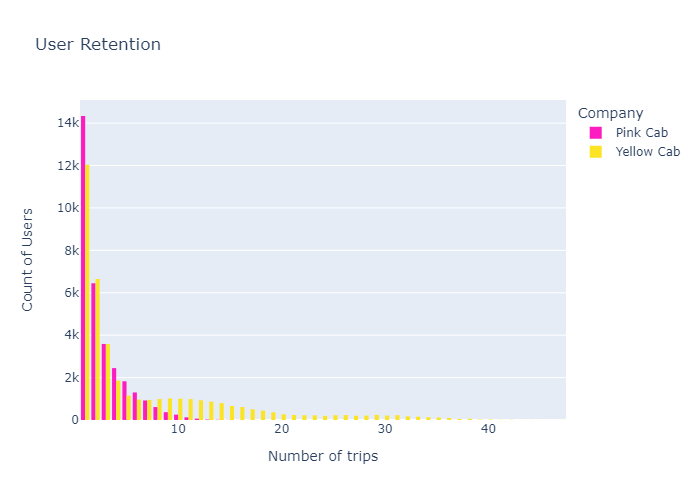

In [24]:
#User Retention
ren_df = data.groupby(['Company', 'Customer ID']).agg({"Users":"count"}).reset_index()
fig = px.histogram(ren_df, x="Users", color= "Company", barmode='group', title="User Retention",
             color_discrete_map={'(?)':'black', 'Pink Cab':'#FC1CBF', 'Yellow Cab':'#FBE426'})
fig.update_yaxes(title_text='Count of Users')
fig.update_xaxes(title_text='Number of trips')
fig.show('png')

## Summary
It is clearly that the number of users decrease by increasing the number of trips. 
For people riding only first time, Pink Cab is the top choice with more than 14k users for the first time riding under 2KM. Maximum number of customer for both companies for the first time was more than 14k for Pink Cab and nearly 12k for Yellow Cab.However, after 7 trips, people tend to ride with Yellow Cab compared to Pink Cab. 

## 10) Is gender affect the Profit in both companies?

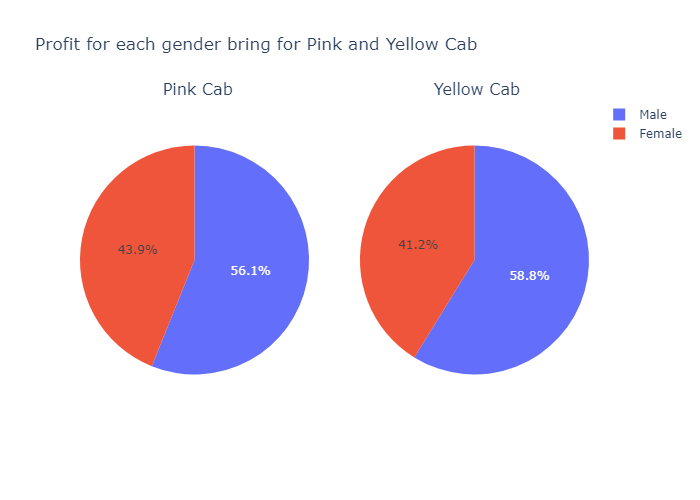

In [25]:
#Profit for each gender in both companies analysis
gen_y=data[data.Company=='Yellow Cab'].groupby('Gender').agg({"Profit":"sum"})
gen_p=data[data.Company=='Pink Cab'].groupby('Gender').agg({"Profit":"sum"})

#Reset index to column
gen_p.reset_index(inplace=True)
gen_y.reset_index(inplace=True)
#Create plot
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]],
                    subplot_titles=(" Pink Cab", " Yellow Cab") )


pie_1 = px.pie(gen_p, values='Profit', names='Gender', 
              title='Percentage of Profitd based on Men and Women')
pie_2 = px.pie(gen_y, values='Profit', names='Gender', 
              title='Percentage of Profit based on  Men and Women ')

#Location of subplots
for trace in pie_1.data:
    fig.add_trace(trace, 1, 1)
for trace in pie_2.data:
    fig.add_trace(trace, 1, 2)
# Options of bar chart
fig.update_layout(title_text='Profit for each gender bring for Pink and Yellow Cab')
fig.show('png')

In general, Male customer brought more profits for both companies. For Yellow Cab, Male customers brought around 25 million dollars compared to 18 million dollars by women. 

Pink company also has the same pattern with Male customers accounted more than 50% percentage of profit brought to the company with nearly 3 million dollars compared to 2.3 million dollars with Female Customers.

However, we need to conduct t-test to find the correlation between gender and profit to decide gender really made an impact to profits for two companies 


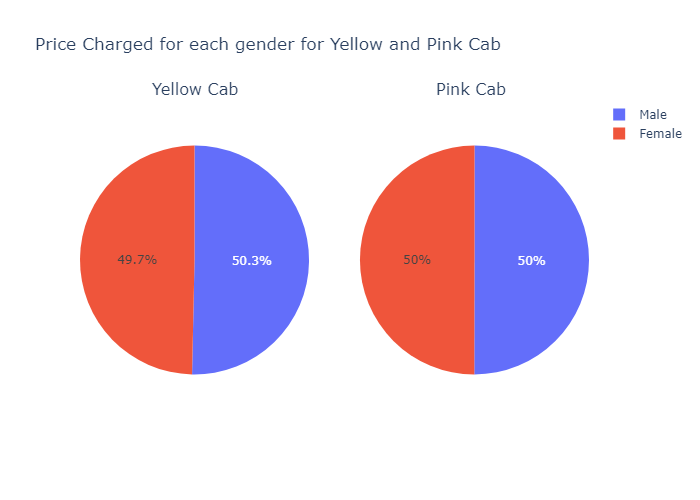

In [31]:
#Price Charged for each gender in both companies analysis
price_y=data[data.Company=='Yellow Cab'].groupby('Gender').agg({"Price Charged":"mean"})
price_p=data[data.Company=='Pink Cab'].groupby('Gender').agg({"Price Charged":"mean"})

#Reset index to column
price_y.reset_index(inplace=True)
price_p.reset_index(inplace=True)


#Create plot
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]],
                    subplot_titles=("Yellow Cab", "Pink Cab ") )


pie_1 = px.pie(price_y, values='Price Charged', names='Gender', 
              title='Price Charged based on Men and Women')
pie_2 = px.pie(price_p, values='Price Charged', names='Gender', 
              title='Price Charged based on  Men and Women ')

#Location of subplots
for trace in pie_1.data:
    fig.add_trace(trace, 1, 1)
for trace in pie_2.data:
    fig.add_trace(trace, 1, 2)
# Options of bar chart
fig.update_layout(title_text='Price Charged for each gender for Yellow and Pink Cab')
fig.show('png')

Female Customers riding with Yellow Cab had been charged less than Male whereas both Male and Female customers riding with Pink Cab had been charged the same.


### Conduct t-test 

### Is the difference in Gender has an impact for Profit in both companies?



In [33]:
#Conduct t-test to measure the difference between Trasaction and Gender in both companies
#Yellow Cab 
F = data[(data.Gender=='Female')&(data.Company=='Yellow Cab')].groupby('Transaction').Profit.mean()
M = data[(data.Gender=='Male')&(data.Company=='Yellow Cab')].groupby('Transaction').Profit.mean()
print(F.shape[0],M.shape[0])


#import scipy to conduct testing hypothesis T-test
from scipy import stats

t, p_value = stats.ttest_ind(a = F.values,b=M.values,equal_var=True)
if(p_value<0.05):
    print('We accept alternate hypothesis that there is a statistical difference in Yellow Cab between gender ')
else:
    print('We accept null hypothesis that there is no statistical difference in Yellow Cab between gender')
    
print('P value is ', p_value)


#Pink Cab
F = data[(data.Gender=='Female')&(data.Company=='Pink Cab')].groupby('Transaction').Profit.mean()
M = data[(data.Gender=='Male')&(data.Company=='Pink Cab')].groupby('Transaction').Profit.mean()
print(F.shape[0],M.shape[0])

t, p_value = stats.ttest_ind(a = F.values,b=M.values,equal_var=True)
if(p_value<0.05):
    print('We accept alternate hypothesis that there is a statistical difference in Pink Cab between gender')
else:
    print('We accept null hypothesis that there is no statistical difference in Pink Cab between gender')
    
print('P value is ', p_value)

116000 158681
We accept alternate hypothesis that there is a statistical difference in Yellow Cab between gender 
P value is  6.060473042494144e-25
37480 47231
We accept null hypothesis that there is no statistical difference in Pink Cab between gender
P value is  0.11515305900425798


## Summary:
Yellow Cab: There is difference in Profit between Male and Female customers
Pink Cab: There is no difference in Profit between Male and Female customers

For Yellow Cab, gender really matter in generating profit. Male Customers tend to brings more profit compared to Pink Cab. However, there are no gender different in Profit for Male and Female customers. The reason it could be because Pink Cab charged the same amount of money regrading its gender. 


# Conclusion 

After careful analysis, we highly suggest to invest in Yellow Cab rather than Pink Cab for a better and safer investment. Firstly, Yellow Cab clearly is leading, and accounted more than 70% the profit, customers, and and customer retention compared to the Pink Cab. For the travel frequency aspect, Yellow Cab is the top choice for customers when riding on weekends, and 70% of customers choose Yellow Cab for riding in many cities. In some the most populated cities in the US, espcially in New York, Chicago, Los Angeles, and Washington, the number of customers in Yellow Cab always higher than Pink Cab and these cities also  where the Yellow Cab's profit came from. 

Secondly, about the profit aspect, Yellow Cab had made higher profit than Pink Cab in most of big cities, and other cities from 2016 to 2018. One of the reason for Yellow Cab's profit could be due to  their price charge. Price Charged has a strong positive correlation with Distance, and the more distance in KM customers ride the more profit cab companies can make. Yellow Cab has higher price charged compared to Pink Cab charged the same amount of money regrading their genders. Most of the profit of Yellow Cab came from Male customers, and its might have an impact to their profits. 

Last but not least, Pink Cab is the most favorite for customers for their first ride while customers tend to pick yellow cab after 7 trips riding with both cab companies. 

# Recommendation

There are some populated cities in the US like Orange County, Silicon Valley, and Mimami, where population above 1 million people and the average income also above 5000 USD dollar per month, that will be a good choice for Yellow Cab's expansion.  



